In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
from matplotlib import pyplot as plt
from pylamp.neural.layers import Linear
from pylamp.neural.activations import Sigmoid, TanH, ReLU
from pylamp.optim.optimizer import SGD
from pylamp.loss.losses import BCELoss, MSELoss
from pylamp.utils.data import DataGenerator as dg 
from pylamp.neural.sequentiel import Sequentiel
from pylamp.optim.optimizer import Optim

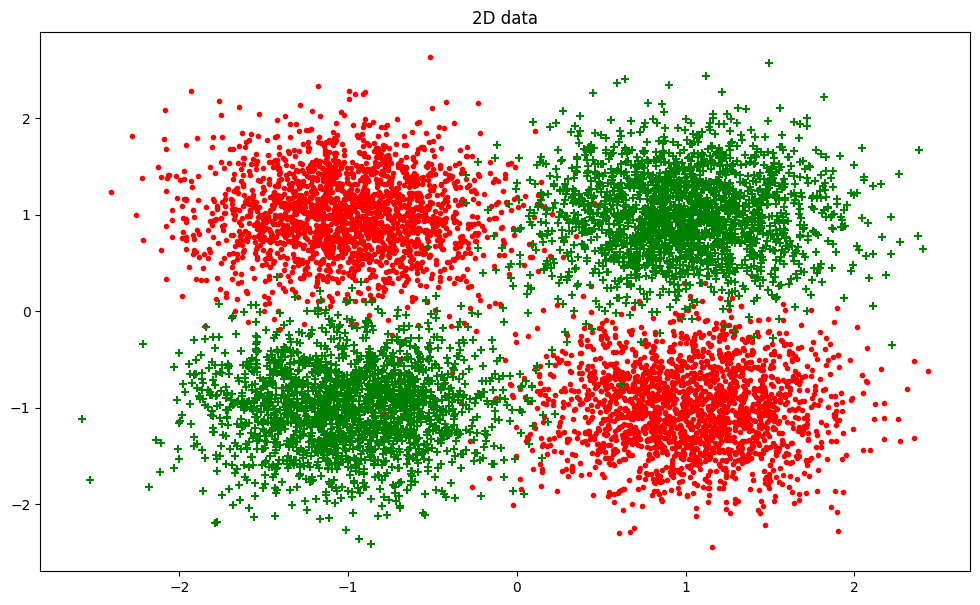

In [11]:
X_train, X_test, y_train, y_test  = dg.generate_2D_data(data_type=1, epsilon=0.3, train_size=0.8, nbex=10000)
dg.plot_2D_data(X_train, y_train)

In [12]:
class ModelTest():
    def __init__(self, models) -> None:
        self.models = models
    
    def forward(self,X):
        output = X 
        for model in self.models:
            output = model.forward(output)
        return output

In [13]:
input_size = X_train.shape[1]
hidden_size = 8
output_size = y_train.shape[1]

print(f'input_size: {input_size}, output_size: {output_size}')

fc1 = Linear(input_size, hidden_size, use_bias=True)
fc2 = Linear(hidden_size, output_size, use_bias=True)
tanh = TanH()
sigmoid = Sigmoid()
model_to_plot = ModelTest([fc1,tanh,fc2,sigmoid])
loss = BCELoss()
train_loss = SGD.step_multiple(
    fc1,fc2,tanh,sigmoid, loss, X_train=X_train, y_train=y_train, 
    epochs=300, lr=1e-3, batch_size=256, verbose=True,
    plot_boundary = True, model_to_plot=model_to_plot
)

Epoch 270 : Train loss : 0.032363494545294046
Model updated 9300 times.


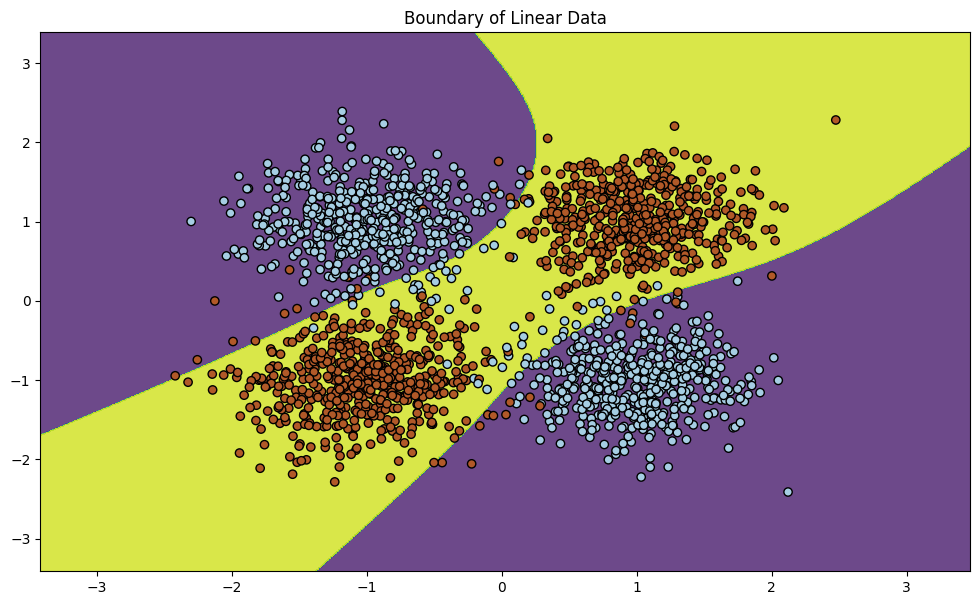

In [14]:
dg.plot_decision_boundary(X_test, y_test, model_to_plot, "Boundary of Linear Data")

## Testing Sequentiel model

In [56]:
# Create a sequential model
model = Sequentiel()

# Add modules to the sequential model
model.add_module(Linear(input_size=2, output_size=8))
model.add_module(TanH())
model.add_module(Linear(input_size=8, output_size=1))
model.add_module(Sigmoid())

loss_func = BCELoss()

optimizer = Optim(model,loss_func,1e-3)

batch_size = 25
epochs = 1000

losses = SGD(optimizer,X_train, y_train, batch_size,epochs,verbose=True)


Epoch 1/1000, Average Loss: 1.0622269356619898
Epoch 101/1000, Average Loss: 0.14382688807862748
Epoch 201/1000, Average Loss: 0.11121005689740338
Epoch 301/1000, Average Loss: 0.09664984038999533
Epoch 401/1000, Average Loss: 0.08729743036427515
Epoch 501/1000, Average Loss: 0.08047424088741499
Epoch 601/1000, Average Loss: 0.07527958262818608
Epoch 701/1000, Average Loss: 0.07126092097930384
Epoch 801/1000, Average Loss: 0.06813613982842102
Epoch 901/1000, Average Loss: 0.06570180658451547
Training finished.


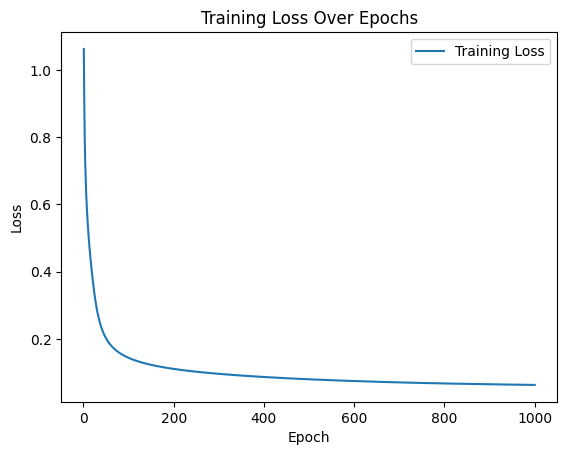

In [58]:
epochs = range(1, len(losses) + 1)
plt.plot(epochs, losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

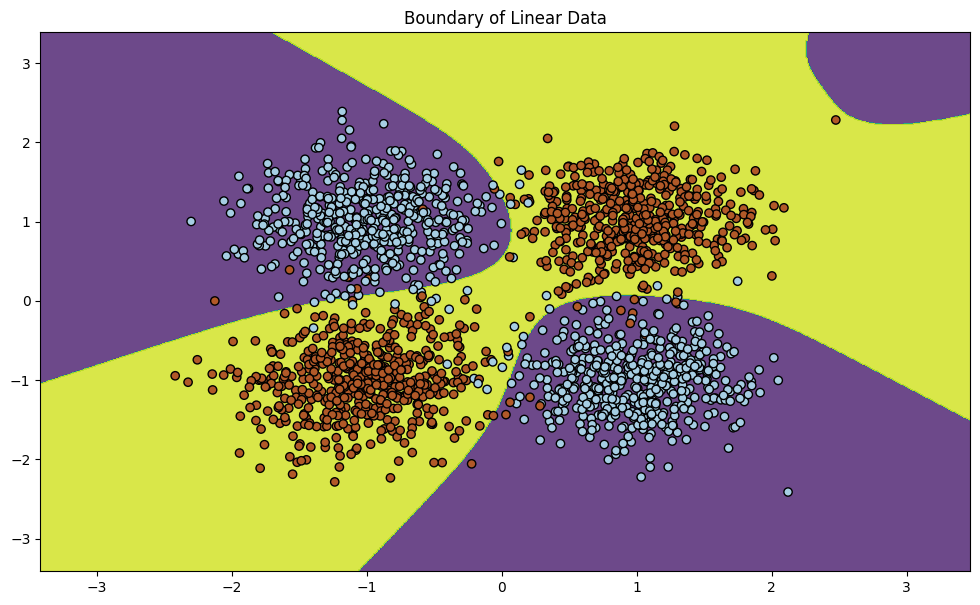

In [59]:
dg.plot_decision_boundary(X_test, y_test, model, "Boundary of Linear Data")
